In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy as sp
import bh_spectrum as libspec
%matplotlib inline

<h4>スペクトルFITSデータ、波長データ読み込み</h4>

In [20]:
# 169625 w/o B injection, 169626 w/ B injection
hdu_sn169625_133m = fits.open('./133mVis_169625.fits')[0]
hdu_sn169626_133m = fits.open('./133mVis_169626.fits')[0]

# 1列目の連番を読み飛ばし # Skip the serial numbers in the first column
df_wl_133m = pd.read_csv('./133mVis_wavcal.csv', header=None, usecols=range(1, 1025))

<h4>ヘッダ確認</h4>

In [3]:
# FITSデータヘッダ確認（Andorヘッダ情報）# FITS data header confirmation (Andor header information)
#hdu_sn169625_133m.header 

#### 定数 constants

In [4]:
# 全視線数 Total number of lines of sight
TOTAL_CH_133M = 44

# 全フレーム数（Kinetic mode 0.2 sサイクル） Total number of frames
TOTAL_FRAME_133M = 50

# 解析するフレーム The frame to analyze
TARGET_FRAME_133M = 38

# 露光時間（FITSヘッダより）Exposure time (from FITS header)
T_EXP_133M = 0.177

# ダイバータ視線 (ch31) Diverter line of sight (ch31)
CH_DIV_133M = 31

#### 川手NF論文 Fig.4(d2)の作成 Fig. 4(d2) in Kawate NF paper

In [5]:
plt.rcParams["font.size"] = 18
print(hdu_sn169626_133m.data.shape)
spec = np.sum(hdu_sn169626_133m.data[:,:,456:642], axis=2) # 433.0-433.9 nm Q枝 (branch)

(50, 44, 1024)


In [8]:
spec.shape

(50, 44)

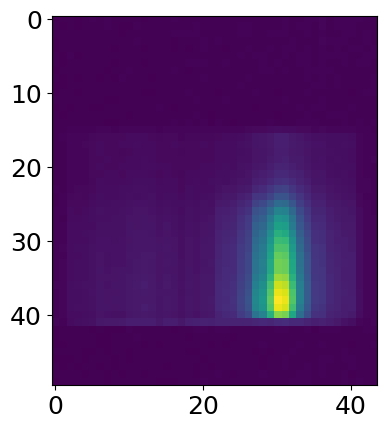

In [6]:
plt.imshow(spec)

(50, 44, 1024)
(50, 44)


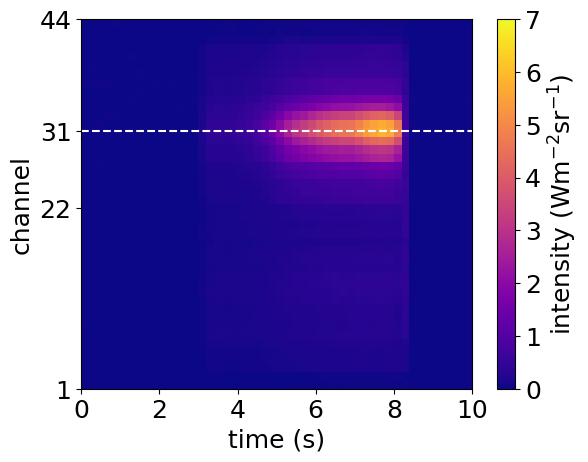

In [7]:
plt.rcParams["font.size"] = 18
print(hdu_sn169626_133m.data.shape)
spec = np.sum(hdu_sn169626_133m.data[:,:,456:642], axis=2) # 433.0-433.9 nm Q枝 (branch)
print(spec.shape)

# バックグラウンド減算 # バックグラウンド減算
spec = spec - spec[49, 43] 

# 感度係数 # Sensitivity coefficient
C_133m = 0.0001837
spec *= C_133m

# グラフ
spec = np.fliplr(spec)
x = np.linspace(0, 10, 50)
y = np.linspace(1, 44, 44)

fig, ax = plt.subplots()
im = ax.imshow(spec.T, cmap='plasma', aspect=0.22,
               extent=[x.min(), x.max(), y.min(), y.max()],
               interpolation='none', vmin=0, vmax=7)

cbar = plt.colorbar(im, ticks=range(8))
cbar.set_label(r'intensity (Wm$^{-2}$sr$^{-1}$)')

ax.set_xlabel('time (s)')
ax.set_ylabel('channel')
ax.set_xlim(0, 10)
ax.set_ylim(1, 44)
ax.set_yticks([1, 22, 31, 44])
ax.hlines(31, 0, 10, color='w', linestyles='dashed')
#plt.vlines(7.6, 1, 44, color='w', linestyles='dashed')

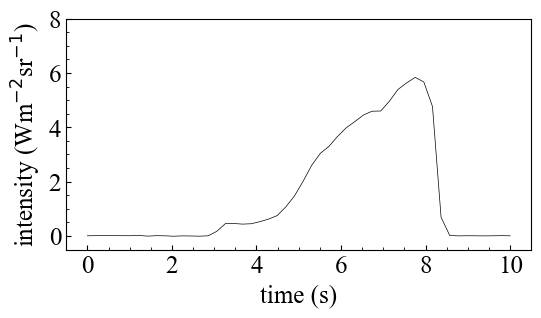

In [10]:
spec_slice = spec[:,44 - 31]

fig, ax = plt.subplots(figsize=(6,3))

ax.minorticks_on()
ax.set_ylim(-0.5, 8)
ax.set_yticks([0, 2, 4, 6, 8])
ax.set_ylabel('intensity (Wm$^{-2}$sr$^{-1}$)')
ax.set_xlabel('time (s)')
ax.plot(x, spec_slice, color='k', lw=0.5)

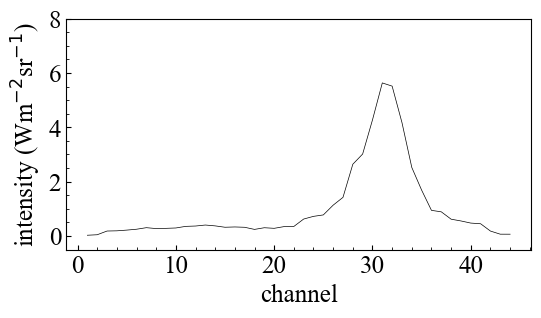

In [11]:
spec_slice2 = np.flip(spec[37,:])

fig, ax = plt.subplots(figsize=(6,3))

ax.minorticks_on()
ax.set_ylim(-0.5, 8)
ax.set_yticks([0, 2, 4, 6, 8])
ax.set_ylabel('intensity (Wm$^{-2}$sr$^{-1}$)')
ax.set_xlabel('channel')
ax.plot(y, spec_slice2, color='k', lw=0.5)

#### t = 7.4-7.6 s（フレーム38）のスペクトル (Frame 38) Spectrum

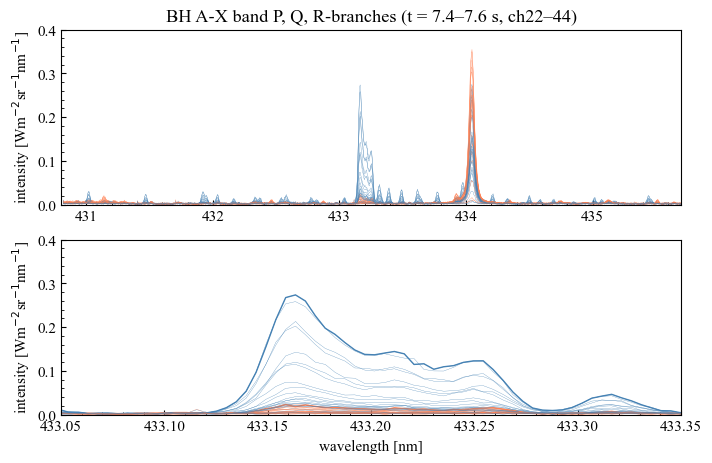

In [12]:
# --- Calibration parameters ---
C_133m = 0.0001837

# --- Allocate and calibrate intensity arrays ---
def calibrate(data, frame_idx, total_ch, coeff):
    out = np.empty((total_ch, data.shape[-1]))
    for ch in range(total_ch):
        row = data[frame_idx - 1, ch]
        out[ch] = (row - row.min()) * coeff
    return out

int_sn169625_133m_calib = calibrate(hdu_sn169625_133m.data, TARGET_FRAME_133M, TOTAL_CH_133M, C_133m)
int_sn169626_133m_calib = calibrate(hdu_sn169626_133m.data, TARGET_FRAME_133M, TOTAL_CH_133M, C_133m)

# --- Plotting ---
plt.rcParams["font.size"] = 11
fig, axes = plt.subplots(2, 1, figsize=(8, 5))
fig.align_ylabels()

# Axis settings
axes[0].set(title='BH A-X band P, Q, R-branches (t = 7.4–7.6 s, ch22–44)',
            xlim=(430.8, 435.7), ylim=(0, 0.4),
            ylabel='intensity [Wm$^{-2}$sr$^{-1}$nm$^{-1}$]')
axes[1].set(xlim=(433.05, 433.35), ylim=(0, 0.4),
            xlabel='wavelength [nm]',
            ylabel='intensity [Wm$^{-2}$sr$^{-1}$nm$^{-1}$]')

for ax in axes:
    ax.minorticks_on()

# --- Plot data ---
for ch in range(21, 44):
    wl = df_wl_133m.iloc[ch].T
    y1 = int_sn169625_133m_calib[ch]
    y2 = int_sn169626_133m_calib[ch]

    axes[0].plot(wl, y1, lw=0.2, color='coral')
    axes[0].plot(wl, y2, lw=0.2, color='steelblue')
    axes[1].plot(wl, y1, lw=0.2, color='coral')
    axes[1].plot(wl, y2, lw=0.2, color='steelblue')

    if ch == CH_DIV_133M - 1:
        axes[1].plot(wl, y1, lw=1, color='coral', label='#w/o B injection')
        axes[1].plot(wl, y2, lw=1, color='steelblue', label='#w/  B injection')

#plt.savefig('spec_ch22-44_overall.png',dpi=200,bbox_inches='tight')


#### IgorProグラフ作成用にcsvファイルに書き出し。Export to csv file for IgorPro graphing.

In [13]:
#import csv
#from itertools import zip_longest
#
#with open('frame38_ch31.csv', 'w', newline='') as f:
#    writer = csv.writer(f)
#    writer.writerow(['wl', 'w/o B', 'w/ B'])    # ヘッダー
#    writer.writerows(zip_longest(df_wl_133m.iloc[CH_DIV_133M - 1].T, int_sn169625_133m_calib[CH_DIV_133M - 1], int_sn169626_133m_calib[CH_DIV_133M - 1]))

#### t = 7.4-7.6 s（フレーム38）のスペクトルフィッティング Spectral fitting for t =

In [14]:

def format_fit_parameters(params, cov, param_names=None, units=None):
    if param_names is None:
        param_names = [f"param_{i}" for i in range(len(params))]
    if units is None:
        units = [""] * len(params)

    errors = np.sqrt(np.diag(cov))

    def format_entry(name, val, err, unit):
        if name.lower() == "t_rot":
            val = int(np.round(val, -2))
            err = int(np.round(err, -2))
            return f"{val} ± {err} {unit}".strip()
        elif err < 1e-3:
            return f"{val:.6f} ± {err:.1e} {unit}".strip()
        else:
            return f"{val:.5g} ± {err:.2g} {unit}".strip()

    formatted = [
        format_entry(name, val, err, unit)
        for name, val, err, unit in zip(param_names, params, errors, units)
    ]

    return pd.DataFrame({"Parameter": param_names, "Formatted": formatted})


In [15]:
ch = CH_DIV_133M - 1

# initial parameters
# パラメータ初期値 (C, T_rot, dx, w_inst, base, I_R7, I_R8)
param_names = ["C", "T_rot", "dx", "w_inst", "base", "I_R7", "I_R8"]
params_ini = [1, 4000, 0.01, 0.025, 0, 1e-3, 1e-3]
spec = int_sn169626_133m_calib[ch, 475:640]
wl = df_wl_133m.iloc[ch].T
wl = wl[475:640]
params, cov = sp.optimize.curve_fit(libspec.BH_spec_fit, wl, spec, params_ini, bounds=([0, 0, 0, 0, -10, 0, 0],[10, 10000, 1, 0.1, 10, 1, 1]))

# 結果
# print(f'C = {params[0]} +/- {np.sqrt(cov[0,0])}')
# print(f'T_rot = {np.round(params[1], -2):.0f} +/- {np.round(np.sqrt(cov[1,1]), -2):.0f} [K]')
# print(f'dx = {params[2]} +/- {np.sqrt(cov[2,2])}')
# print(f'w_inst = {params[3]} +/- {np.sqrt(cov[3,3])}')
# print(f'base = {params[4]} +/- {np.sqrt(cov[4,4])}')
# print(f'I_R7 = {params[5]} +/- {np.sqrt(cov[5,5])}')
# print(f'I_R8 = {params[6]} +/- {np.sqrt(cov[6,6])}')

int_fit = libspec.BH_spec_fit(wl, params[0], params[1], params[2], params[3], params[4], params[5], params[6])


format_fit_parameters(params,cov,param_names=param_names)


,Parameter,Formatted
0,C,0.26182 ± 0.0023
1,T_rot,3600 ± 100
2,dx,0.004299 ± 7.9e-05
3,w_inst,0.023802 ± 2.1e-04
4,base,0.004010 ± 2.4e-04
5,I_R7,0.000262 ± 3.1e-05
6,I_R8,0.000287 ± 3.1e-05


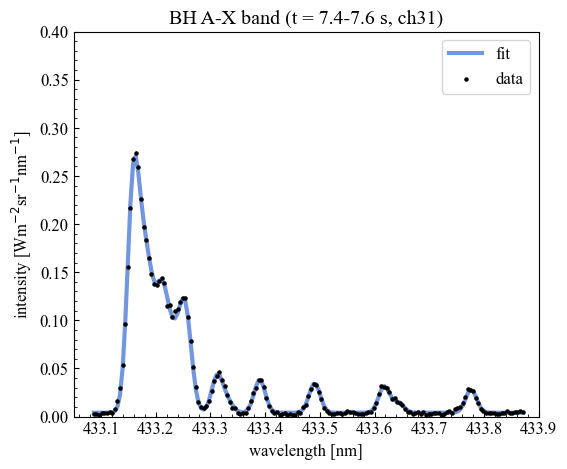

In [17]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6,5))
fig.align_ylabels()

ax.set_xlim(433.05, 433.9)
ax.set_ylim(0, 0.4)
ax.minorticks_on()
ax.set_ylabel('intensity [Wm$^{-2}$sr$^{-1}$nm$^{-1}$]')
ax.set_xlabel('wavelength [nm]')
ax.set_title('BH A-X band (t = 7.4-7.6 s, ch31)')
ax.plot(wl, int_fit, color='#7397de', lw=3, label='fit',zorder=1)
ax.scatter(wl, spec, s=5, color='k', label='data',zorder=2)

ax.legend()

fig.set_facecolor('none')
#plt.savefig('fit1.png',dpi=300,bbox_inches='tight',transparent=True, facecolor='none')

In [19]:
ch = 24

# パラメータ初期値 (x, C, T_rot, dx, w_inst, base, I_R7, I_R8)
param_names = ["C", "T_rot", "dx", "w_inst", "base", "I_R7", "I_R8"]
params_ini = [1, 4000, 0.01, 0.025, 0, 1e-3, 1e-3]
spec = int_sn169626_133m_calib[ch, 475:640]
wl = df_wl_133m.iloc[ch].T
wl = wl[475:640]
params, cov = sp.optimize.curve_fit(libspec.BH_spec_fit, wl, spec, params_ini, bounds=([0, 0, 0, 0, -10, 0, 0],[10, 10000, 1, 0.1, 10, 1, 1]))


int_fit = libspec.BH_spec_fit(wl, params[0], params[1], params[2], params[3], params[4], params[5], params[6])

format_fit_parameters(params,cov,param_names=param_names)

,Parameter,Formatted
0,C,0.031983 ± 9.0e-04
1,T_rot,3300 ± 200
2,dx,0.003549 ± 2.5e-04
3,w_inst,0.023130 ± 6.4e-04
4,base,0.002510 ± 8.6e-05
5,I_R7,0.000018 ± 1.1e-05
6,I_R8,0.000043 ± 1.1e-05


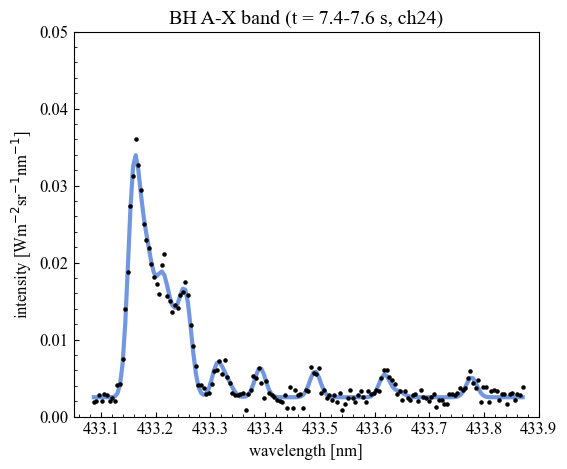

In [20]:
fig, ax = plt.subplots(figsize=(6,5))
fig.align_ylabels()

ax.set_xlim(433.05, 433.9)
ax.set_ylim(0, 0.05)
ax.minorticks_on()
ax.set_ylabel('intensity [Wm$^{-2}$sr$^{-1}$nm$^{-1}$]')
ax.set_xlabel('wavelength [nm]')
ax.set_title('BH A-X band (t = 7.4-7.6 s, ch24)')
ax.plot(wl, int_fit, color='#7397de', lw=3, label='fit',zorder=1)
ax.scatter(wl, spec, s=5, color='k', label='data',zorder=2)
fig.set_facecolor('none')
#plt.savefig('fit2.png',dpi=300,bbox_inches='tight',transparent=True, facecolor='none')

In [22]:
ch_from = 22
ch_to = 41
num_of_ch = ch_to - ch_from + 1

LOS = np.zeros(num_of_ch)
C = np.zeros(num_of_ch)
C_sdev= np.zeros(num_of_ch)
T_rot = np.zeros(num_of_ch)
T_rot_sdev= np.zeros(num_of_ch)
dx = np.zeros(num_of_ch)
dx_sdev= np.zeros(num_of_ch)
w_inst = np.zeros(num_of_ch)
w_inst_sdev= np.zeros(num_of_ch)
base = np.zeros(num_of_ch)
base_sdev= np.zeros(num_of_ch)

for i in range(ch_from - 1, ch_to):
    
    # パラメータ初期値
    params_ini = [1, 4000, 0.01, 0.025, 0, 1e-3, 1e-3]
    spec = int_sn169626_133m_calib[i, 475:640]
    wl = df_wl_133m.iloc[i].T
    wl = wl[475:640]
    params, cov = sp.optimize.curve_fit(libspec.BH_spec_fit, wl, spec, params_ini, bounds=([0, 0, 0, 0, -10, 0, 0],[10, 10000, 1, 0.1, 10, 1, 1]))
    
    index = i - (ch_from - 1)
    
    LOS[index] = i + 1
    C[index] = params[0]
    C_sdev[index] = np.sqrt(cov[0,0])
    T_rot[index] = params[1]
    T_rot_sdev[index] = np.sqrt(cov[1,1])
    dx[index] = params[2]
    dx_sdev[index] = np.sqrt(cov[2,2])
    w_inst[index] = params[3]
    w_inst_sdev[index] = np.sqrt(cov[3,3])
    base[index] = int(params[4])
    base_sdev[index] = np.sqrt(cov[4,4])
    
# 結果
df = pd.DataFrame({"LOS" : LOS, "C" : C, "C_sdev" : C_sdev, "T_rot" : T_rot, "T_rot_sdev" : T_rot_sdev, "dx" : dx, "dx_sdev" : dx_sdev, "w_inst" : w_inst, "w_inst_sdev" : w_inst_sdev, "base" : base, "base_sdev" : base_sdev})
#df.to_csv("./fitting_results.csv", index=False)

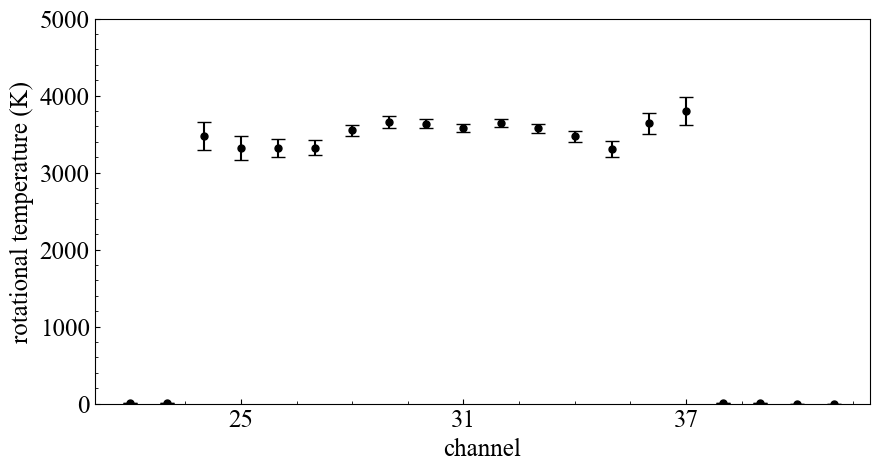

In [72]:
# グラフ
plt.rcParams["font.size"] = 18
fig, ax = plt.subplots(figsize=(10,5))

ax.set_xticks([25, 31, 37])
ax.set_ylabel('rotational temperature (K)')
ax.set_xlabel('channel')

ax.minorticks_on()
ax.set_ylim(0, 5000)

ax.errorbar(LOS, T_rot, yerr=T_rot_sdev, capsize=5, fmt='o', markersize=5, ecolor='k', markeredgecolor = "k", color='k')


# ax.plot(wl, int_fit, color='#7397de', lw=3, label='fit',zorder=1)
# ax.scatter(wl, spec, s=5, color='k', label='data',zorder=2)
fig.set_facecolor('none')
plt.savefig('spatial.png',dpi=300,bbox_inches='tight',transparent=True, facecolor='none')

In [17]:
ch_from = 22
ch_to = 41
#ch_from = 26
#ch_to = 36
num_of_ch = ch_to - ch_from + 1

frame_from = 15
frame_to = 42
#frame_from = 15
#frame_to = 40
num_of_frame = frame_to - frame_from + 1

C = np.zeros((num_of_frame, num_of_ch))
C_sdev= np.zeros((num_of_frame, num_of_ch))
T_rot = np.zeros((num_of_frame, num_of_ch))
T_rot_sdev= np.zeros((num_of_frame, num_of_ch))
dx = np.zeros((num_of_frame, num_of_ch))
dx_sdev= np.zeros((num_of_frame, num_of_ch))
w_inst = np.zeros((num_of_frame, num_of_ch))
w_inst_sdev= np.zeros((num_of_frame, num_of_ch))
base = np.zeros((num_of_frame, num_of_ch))
base_sdev= np.zeros((num_of_frame, num_of_ch))

# 感度係数
C_133m = 0.0001837

while False:
#for i in range(frame_from - 1, frame_to):
    for k in range(TOTAL_CH_133M):
        int_sn169626_133m_calib[k] = hdu_sn169626_133m.data[i - 1, k]
        int_sn169626_133m_calib[k] -= np.min(int_sn169626_133m_calib[k])
        int_sn169626_133m_calib[k] *= C_133m
    
    for j in range(ch_from - 1, ch_to):
        # パラメータ初期値
        params_ini = [1, 4000, 0.01, 0.025, 0, 1e-3, 1e-3]
        spec = int_sn169626_133m_calib[j, 475:640]
        wl = df_wl_133m.iloc[j].T
        wl = wl[475:640]
        
        try:
            params, cov = scipy.optimize.curve_fit(libspec.BH_spec_fit, wl, spec, params_ini, bounds=([0, 0, 0, 0, -10, 0, 0],[10, 10000, 1, 0.1, 10, 1, 1]))
        except RuntimeError:
            continue
    
        idx1 = i - (frame_from - 1) 
        idx2 = j - (ch_from - 1)
            
        C[idx1, idx2] = params[0]
        C_sdev[idx1, idx2] = np.sqrt(cov[0,0])
        T_rot[idx1, idx2] = params[1]
        T_rot_sdev[idx1, idx2] = np.sqrt(cov[1,1])
        dx[idx1, idx2] = params[2]
        dx_sdev[idx1, idx2] = np.sqrt(cov[2,2])
        w_inst[idx1, idx2] = params[3]
        w_inst_sdev[idx1, idx2] = np.sqrt(cov[3,3])
        base[idx1, idx2] = int(params[4])
        base_sdev[idx1, idx2] = np.sqrt(cov[4,4])

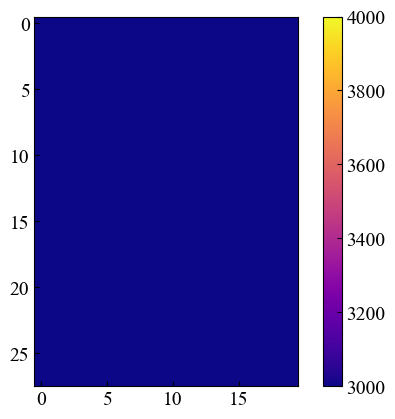

In [18]:
fig, ax = plt.subplots()
im = ax.imshow(T_rot, cmap='plasma', interpolation='none',  vmin=3000, vmax=4000)
plt.colorbar(im)
plt.show()